# **Diplomado IA: Audio y Video - Parte 2**. <br> Práctico 5: Aplicaciones de Audio y Video
---
---

**Profesores:**
- Alain Raymond
- Gabriel Sepúlveda
- Andrés Villa
- Vladimir Araujo
- Felipe Ríos

**Ayudante:**
- Cristóbal Eyzaguirre
---
---

El siguiente práctico se debe realizar de forma individual. El formato de entregar es el **archivo .ipynb con todas las celdas ejecutadas**. Las secciones donde se planteen preguntas de forma explícita, deben ser respondida en celdas de texto, y no se aceptará solo el _output_ de una celda de código como respuesta.

**Nombre alumno:**

El siguiente práctico cuanta con 3 secciones donde cada una contendrá 1 o más actividades a realizar. Algunas actividades corresponderán a escribir código y otras a responder preguntas. 

Antes de responder, se recomienda **fuertemente** revisar las secciones previas donde se desarrollan los ejemplos, dado que algunas de las actividades pueden ser completadas reutilizando el mismo código.

**Fecha de entrega:** lunes 24 de mayo de 2021, 23:59 hrs.

---
**IMPORTANTE:** habrá un bonus de 1 décima para todos aquellos alumnos/as que muestren buen orden en sus respuestas (esto aplica a legibilidad de código, buena redacción, formalidad, organización del jupyter notebook, seguimiento de instrucciones, etc). El criterio lo pondrá cada ayudante corrector. La nota máxima obtenible en el laboratorio es 7.0

## Detectando el Origen de Sonidos en Videos usando PixelPlayer

En este laboratorio práctico, trabajaremos resolviendo el siguiente problema: cómo detectar el origen de un sonido dentro de un video. Para esto nos basaremos en el trabajo *The Sound of Pixels* (https://arxiv.org/pdf/1804.03160.pdf) en el que de manera **no supervisada** una red aprende a distinguir de dónde proviene el sonido en un video.

La implementación de este modelo es más o menos sofisticada, por lo que iremos viendo algunas de las piezas claves para tratar de entender mejor que está sucediendo. La implementación que vamos a ocupar viene de: https://github.com/hangzhaomit/Sound-of-Pixels.

Sin embargo, este repositorio estaba incompleto, por lo que lo extendimos con algunos arreglos de errores y algunas funcionalidades extra para este laboratorio en: https://github.com/alainray/Sound-of-Pixels.

Partamos por entender, con qué datos trabajaremos:

### El Dataset MUSIC

Este dataset está basado en videos de Youtube de personas tocando instrumentos musicales de manera solitaria o en conjunto. Hay varios tipos de instrumentos representados como acordeón, flauta o xilófono. Veamos un ejemplo:

In [1]:
from IPython.display import HTML

HTML('<iframe width="180" height="315" src="https://www.youtube.com/embed/E_8W7f9ZZpY" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

La descarga y procesamiento del dataset toman bastante tiempo, por lo que vamos a trabajar con una subconjunto ya preprocesado del dataset completo. Si les interesa ver cómo se hace la descarga y el procesamiento, pueden ver todo el código al final de este laboratorio.

### Descarga del Dataset (~7 minutos)

In [2]:
!gdown --id 1Casru-12S2c50CrOhz-N811U6rKH7NiA

Downloading...
From: https://drive.google.com/uc?id=1Casru-12S2c50CrOhz-N811U6rKH7NiA
To: /content/MUSIC_proc.tar.gz
9.83GB [03:36, 45.4MB/s]


In [3]:
!gdown --id 1c3-wpN22r2AaU2yD_V0ZNqjpesnor8YP

Downloading...
From: https://drive.google.com/uc?id=1c3-wpN22r2AaU2yD_V0ZNqjpesnor8YP
To: /content/MUSIC_proc_sample.tar.gz
286MB [00:02, 96.0MB/s]


In [4]:
!tar -xzf MUSIC_proc.tar.gz

In [5]:
!tar -xzf MUSIC_proc_sample.tar.gz

### Clase Dataset: MusicMixDataset

In [ ]:
# No ejecutar esta celda, es para fines didácticos
import os
import random
from .base import BaseDataset


class MUSICMixDataset(BaseDataset):
    def __init__(self, list_sample, opt, **kwargs):
        super(MUSICMixDataset, self).__init__(
            list_sample, opt, **kwargs)
        self.fps = opt.frameRate
        self.num_mix = opt.num_mix

    def __getitem__(self, index):
        N = self.num_mix
        frames = [None for n in range(N)]
        audios = [None for n in range(N)]
        infos = [[] for n in range(N)]
        path_frames = [[] for n in range(N)]
        path_audios = ['' for n in range(N)]
        center_frames = [0 for n in range(N)]

        # the first video
        infos[0] = self.list_sample[index]

        # sample other videos
        if not self.split == 'train':
            random.seed(index)
        for n in range(1, N):
            indexN = random.randint(0, len(self.list_sample)-1)
            infos[n] = self.list_sample[indexN]

        # select frames
        idx_margin = max(
            int(self.fps * 8), (self.num_frames // 2) * self.stride_frames)
        for n, infoN in enumerate(infos):
            path_audioN, path_frameN, count_framesN = infoN

            if self.split == 'train':
                # random, not to sample start and end n-frames
                center_frameN = random.randint(
                    idx_margin+1, int(count_framesN)-idx_margin)
            else:
                center_frameN = int(count_framesN) // 2
            center_frames[n] = center_frameN

            # absolute frame/audio paths
            for i in range(self.num_frames):
                idx_offset = (i - self.num_frames // 2) * self.stride_frames
                path_frames[n].append(
                    os.path.join(
                        path_frameN,
                        '{:06d}.jpg'.format(center_frameN + idx_offset)))
            path_audios[n] = path_audioN

        # load frames and audios, STFT
        try:
            for n, infoN in enumerate(infos):
                frames[n] = self._load_frames(path_frames[n])
                # jitter audio
                center_timeN = (center_frames[n] - 0.5) / self.fps
                audios[n] = self._load_audio(path_audios[n], center_timeN)
            mag_mix, mags, phase_mix = self._mix_n_and_stft(audios)

        except Exception as e:
            print('Failed loading frame/audio: {}'.format(e))
            # create dummy data
            mag_mix, mags, frames, audios, phase_mix = \
                self.dummy_mix_data(N)

        ret_dict = {'mag_mix': mag_mix, 'frames': frames, 'mags': mags}
        if self.split != 'train':
            ret_dict['audios'] = audios
            ret_dict['phase_mix'] = phase_mix
            ret_dict['infos'] = infos

        return ret_dict

En resumidas cuentas, la labor a alto nivel de esta clase es conseguirnos:
* Los frames de los N videos.
* El audio mezclado de los N videos
* Los audios originales de los N videos.

## El modelo: PixelPlayer

Ahora discutiremos un poco de la arquitectura detrás de PixelPlayer. Un diagrama a continuación:

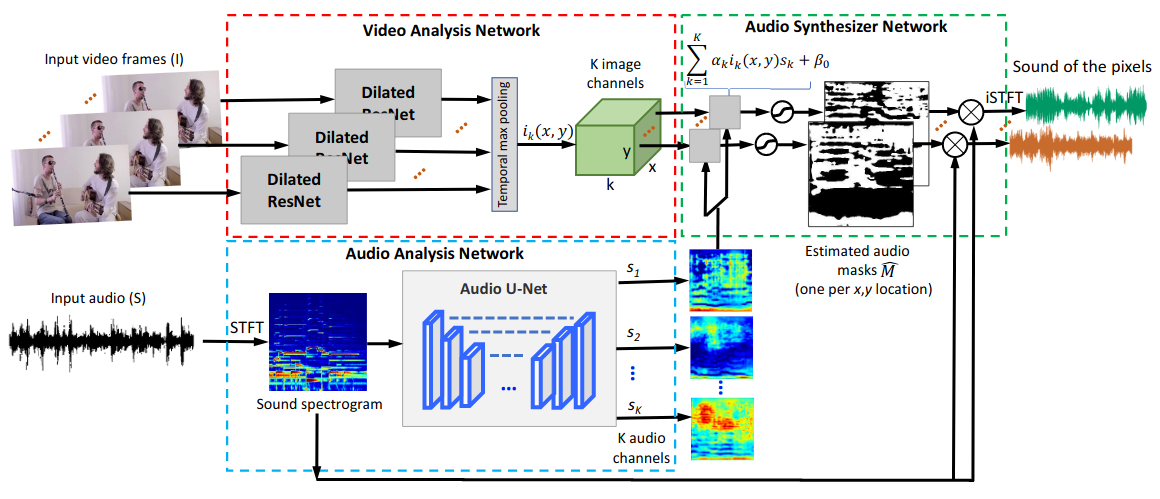

*Arquitectura del modelo PixelPlayer*. Nótese la división en tres submódulos: Video, Audio y Síntesis de Audio. El modelo funciona combinando features de audio y video para intentar predecir el espectrograma correcto de audio para el video ingresado.

El modelo consiste en 3 componentes:

* **Video Analysis Network:** Resnet con convoluciones dilatadas. Max Pooling Temporal. 
* **Audio Analysis Network:** Utilizar una U-Net.
* **Audio Synthetizer Network:** Es un módulo muy sencillo que hace producto punto entre un conjunto de parámetros aprendido y los datos de audio y video.


## PixelPlayer

Aquí está el código que define la estructura de `PixelPlayer`. El repositorio es más complejo que sólo este código, por lo que exploraremos algunas partes esenciales por temas didácticos. En particular, podemos ver la definición de los 3 bloques esenciales de la arquitectura y el flujo de los datos a través del modelo. Descarguemos el repositorio y veamos el modelo:


In [7]:
!git clone https://github.com/alainray/Sound-of-Pixels.git

Cloning into 'Sound-of-Pixels'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 169 (delta 37), reused 0 (delta 0), pack-reused 106
Receiving objects: 100% (169/169), 1.27 MiB | 37.23 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [ ]:
# No ejecutar este código, es para fines didácticos
# Network wrapper, defines forward pass
class NetWrapper(torch.nn.Module):
    def __init__(self, nets, crit):
        super(NetWrapper, self).__init__()
        self.net_sound, self.net_frame, self.net_synthesizer = nets
        self.crit = crit

    def forward(self, batch_data, args):
        mag_mix = batch_data['mag_mix']
        mags = batch_data['mags']
        frames = batch_data['frames']
        mag_mix = mag_mix + 1e-10

        N = args.num_mix
        B = mag_mix.size(0)
        T = mag_mix.size(3)

        # 0.0 warp the spectrogram
        if args.log_freq:
            grid_warp = torch.from_numpy(
                warpgrid(B, 256, T, warp=True)).to(args.device)
            mag_mix = F.grid_sample(mag_mix, grid_warp)
            for n in range(N):
                mags[n] = F.grid_sample(mags[n], grid_warp)

        # 0.1 calculate loss weighting coefficient: magnitude of input mixture
        if args.weighted_loss:
            weight = torch.log1p(mag_mix)
            weight = torch.clamp(weight, 1e-3, 10)
        else:
            weight = torch.ones_like(mag_mix)

        # 0.2 ground truth masks are computed after warpping!
        gt_masks = [None for n in range(N)]
        for n in range(N):
            if args.binary_mask:
                # for simplicity, mag_N > 0.5 * mag_mix
                gt_masks[n] = (mags[n] > 0.5 * mag_mix).float()
            else:
                gt_masks[n] = mags[n] / mag_mix
                # clamp to avoid large numbers in ratio masks
                gt_masks[n].clamp_(0., 5.)

        # LOG magnitude
        log_mag_mix = torch.log(mag_mix).detach()

        # 1. forward net_sound -> BxCxHxW
        feat_sound = self.net_sound(log_mag_mix)
        feat_sound = activate(feat_sound, args.sound_activation)

        # 2. forward net_frame -> Bx1xC
        feat_frames = [None for n in range(N)]
        for n in range(N):
            feat_frames[n] = self.net_frame.forward_multiframe(frames[n], not args.img_unpooling)
            feat_frames[n] = activate(feat_frames[n], args.img_activation)

        # 3. sound synthesizer
        pred_masks = [None for n in range(N)]
        for n in range(N):
            if args.img_unpooling:
                pred_masks[n] = self.net_synthesizer.forward_pixelwise(feat_frames[n], feat_sound)
            else:
                pred_masks[n] = self.net_synthesizer(feat_frames[n], feat_sound)
            pred_masks[n] = activate(pred_masks[n], args.output_activation)

        # 4. loss
        if args.img_unpooling:
            err= 0.0 # TODO: Fix so we can get the actual error
        else:
            err = self.crit(pred_masks, gt_masks, weight).reshape(1)

        return err, \
            {'pred_masks': pred_masks, 'gt_masks': gt_masks,
             'mag_mix': mag_mix, 'mags': mags, 'weight': weight}



La decisión de diseño es inusual acá. Dentro de la arquitectura misma del modelo, los autores decidieron incluir el cálculo del ground truth (las máscaras a predecir), junto con las transformaciones de los datos. No hay problema y funciona, es sólo inusual, pues perfectamente se podrían haber calculado en la función `MUSICMixDataset`.

### Video Analysis Network

In [ ]:
from functools import partial
class ResnetDilated(nn.Module):
    def __init__(self, orig_resnet, fc_dim=64, pool_type='maxpool',
                 dilate_scale=16, conv_size=3):
        super(ResnetDilated, self).__init__()
        self.pool_type = pool_type

        if dilate_scale == 8:
            orig_resnet.layer3.apply(
                partial(self._nostride_dilate, dilate=2)) # Customización 1: eliminar Stride y dilatar capa
            orig_resnet.layer4.apply(
                partial(self._nostride_dilate, dilate=4))
        elif dilate_scale == 16:
            orig_resnet.layer4.apply(
                partial(self._nostride_dilate, dilate=2))

        self.features = nn.Sequential(
            *list(orig_resnet.children())[:-2])          # Customización 2: quitar clasificador y avg pooling

        self.fc = nn.Conv2d(                             # Customización 3: agregar bloque convolucional al final
            512, fc_dim, kernel_size=conv_size, padding=conv_size//2)

    # Este método deja el stride en (1,1) y agrega Dilation a la misma
    def _nostride_dilate(self, m, dilate):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            # the convolution with stride
            if m.stride == (2, 2):
                m.stride = (1, 1)
                if m.kernel_size == (3, 3):
                    m.dilation = (dilate//2, dilate//2)
                    m.padding = (dilate//2, dilate//2)
            # other convoluions
            else:
                if m.kernel_size == (3, 3):
                    m.dilation = (dilate, dilate)
                    m.padding = (dilate, dilate)

    # El forward no cambia mucho de una Resnet
    # Fijémonos eso sí que hay dos forward definidos
    # ¿Por qué?
    # Para soportar los modos de entrenamiento e inferencia
    # Nos podemos dar cuenta por las dimensionalidades de salida

    def forward_multiframe(self, x, pool=True):
        (B, C, T, H, W) = x.size()
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        x = x.view(B*T, C, H, W)

        x = self.features(x)
        x = self.fc(x)

        (_, C, H, W) = x.size()
        x = x.view(B, T, C, H, W)
        x = x.permute(0, 2, 1, 3, 4)

        if not pool:
            return x #  B x K x T x H x W

        if self.pool_type == 'avgpool':
            x = F.adaptive_avg_pool3d(x, 1)
        elif self.pool_type == 'maxpool':
            x = F.adaptive_max_pool3d(x, 1)

        x = x.view(B, C) # B x K
        return x

### Audio Analysis Network

In [ ]:
class Unet(nn.Module):
    def __init__(self, fc_dim=64, num_downs=5, ngf=64, use_dropout=False):
        super(Unet, self).__init__()

        # construct unet structure
        unet_block = UnetBlock(
            ngf * 8, ngf * 8, input_nc=None,
            submodule=None, innermost=True)
        for i in range(num_downs - 5):
            unet_block = UnetBlock(
                ngf * 8, ngf * 8, input_nc=None,
                submodule=unet_block, use_dropout=use_dropout)
        unet_block = UnetBlock(
            ngf * 4, ngf * 8, input_nc=None,
            submodule=unet_block)
        unet_block = UnetBlock(
            ngf * 2, ngf * 4, input_nc=None,
            submodule=unet_block)
        unet_block = UnetBlock(
            ngf, ngf * 2, input_nc=None,
            submodule=unet_block)
        unet_block = UnetBlock(
            fc_dim, ngf, input_nc=1,
            submodule=unet_block, outermost=True)

        self.bn0 = nn.BatchNorm2d(1)
        self.unet_block = unet_block

    def forward(self, x):
        x = self.bn0(x)
        x = self.unet_block(x)
        return x


# Defines the submodule with skip connection.
# X -------------------identity---------------------- X
#   |-- downsampling -- |submodule| -- upsampling --|
class UnetBlock(nn.Module):
    def __init__(self, outer_nc, inner_input_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False,
                 use_dropout=False, inner_output_nc=None, noskip=False):
        super(UnetBlock, self).__init__()
        self.outermost = outermost
        self.noskip = noskip
        use_bias = False
        if input_nc is None:
            input_nc = outer_nc
        if innermost:
            inner_output_nc = inner_input_nc
        elif inner_output_nc is None:
            inner_output_nc = 2 * inner_input_nc

        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(inner_input_nc)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(outer_nc)
        upsample = nn.Upsample(
            scale_factor=2, mode='bilinear', align_corners=True)

        if outermost:
            downconv = nn.Conv2d(
                input_nc, inner_input_nc, kernel_size=4,
                stride=2, padding=1, bias=use_bias)
            upconv = nn.Conv2d(
                inner_output_nc, outer_nc, kernel_size=3, padding=1)

            down = [downconv]
            up = [uprelu, upsample, upconv]
            model = down + [submodule] + up
        elif innermost:
            downconv = nn.Conv2d(
                input_nc, inner_input_nc, kernel_size=4,
                stride=2, padding=1, bias=use_bias)
            upconv = nn.Conv2d(
                inner_output_nc, outer_nc, kernel_size=3,
                padding=1, bias=use_bias)

            down = [downrelu, downconv]
            up = [uprelu, upsample, upconv, upnorm]
            model = down + up
        else:
            downconv = nn.Conv2d(
                input_nc, inner_input_nc, kernel_size=4,
                stride=2, padding=1, bias=use_bias)
            upconv = nn.Conv2d(
                inner_output_nc, outer_nc, kernel_size=3,
                padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upsample, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost or self.noskip:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

### Audio Synthetizer Network

Esta es la parte de la red que hace toda la magia de unir de alguna manera los features de sonido con los features de imagen para crear los spectrogramas de salida por pixel. En sí, en términos arquitectónicos, esta parte de la red es sencilla. Consiste en K parámetros y 1 bias.





In [ ]:
class InnerProd(nn.Module):
    def __init__(self, fc_dim):
        super(InnerProd, self).__init__()
        self.scale = nn.Parameter(torch.ones(fc_dim))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, feat_img, feat_sound):
        sound_size = feat_sound.size()
        B, C = sound_size[0], sound_size[1]
        feat_img = feat_img.view(B, 1, C)
        z = torch.bmm(feat_img * self.scale, feat_sound.view(B, C, -1)) \
            .view(B, 1, *sound_size[2:])
        z = z + self.bias
        return z

    def forward_nosum(self, feat_img, feat_sound):
        (B, C, H, W) = feat_sound.size()
        feat_img = feat_img.view(B, C)
        z = (feat_img * self.scale).view(B, C, 1, 1) * feat_sound
        z = z + self.bias
        return z

    # inference purposes
    def forward_pixelwise(self, feats_img, feat_sound):
        (B, C, HI, WI) = feats_img.size()
        (B, C, HS, WS) = feat_sound.size()
        feats_img = feats_img.view(B, C, HI*WI)
        feats_img = feats_img.transpose(1, 2)
        feat_sound = feat_sound.view(B, C, HS * WS)
        z = torch.bmm(feats_img * self.scale, feat_sound) \
            .view(B, HI, WI, HS, WS)
        z = z + self.bias
        return z

### Método de Entrenamiento: Mix + Separate

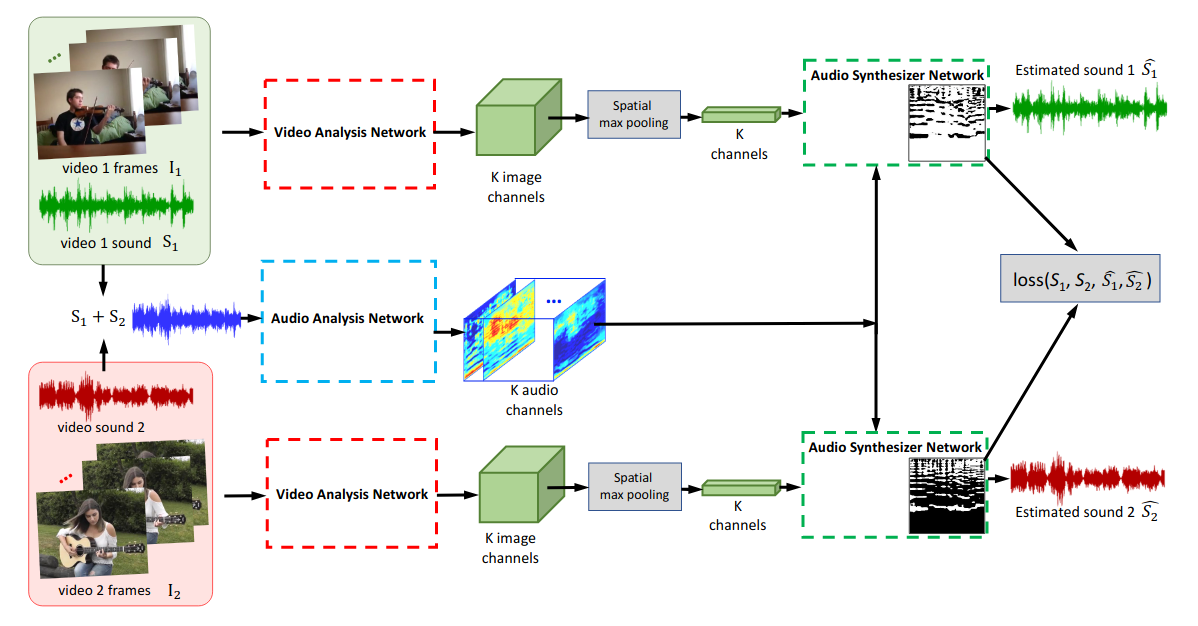



* La manera ingeniosa con que los desarrolladores de `PixelPlayer` supervisaron este modelo sin etiquetas, fue inventando una tarea que le permitiera al modelo aprender algo interesante para la tarea final.

* Esta tarea inventada consiste en *mezclar el sonido* de 2 videos distintos y forzar a la red a ser capaz de separar el sonido correcto del video. Luego la etiqueta, se vuelve el sonido original de ese video. ¿Ingenioso, verdad?

* Una vez entrenado, el modelo se vuelve muy bueno a la hora de detectar cuál debiese ser el sonido asociado a la imagen.

####¿Cómo adquiere la capacidad de ubicarlo a nivel de pixeles?

Inteligentemente, lo que hicieron los autores es generar como salida de los pasos de video y audio vectores de largo K. Luego, al momento de inferencia, lo que se hace es hacer un producto punto entre el vector de largo de cada pixel con el vector de largo K asociado a cada elemento del espectrograma de salida de audio. Esto genera como resultado un espectrograma por cada pixel de salida.

$$\alpha_{k} \cdot I_{B \times K \times H_{i} \times W_{i}} \times A_{B \times H_{a} \times W_{a} \times K } + \beta_{k}= R_{B \times H_{i} \times W_{i} \times H_{a} \times W_{a} }$$

In [ ]:
def train(netWrapper, loader, optimizer, history, epoch, args):
    torch.set_grad_enabled(True)
    batch_time = AverageMeter()
    data_time = AverageMeter()
    # switch to train mode
    netWrapper.train()

    # main loop
    torch.cuda.synchronize()
    tic = time.perf_counter()
    for i, batch_data in enumerate(loader):
        # measure data time
        torch.cuda.synchronize()
        data_time.update(time.perf_counter() - tic)

        # forward pass
        netWrapper.zero_grad()
        err, _ = netWrapper.forward(batch_data, args)
        err = err.mean()

        # backward
        err.backward()
        optimizer.step()

        # measure total time
        torch.cuda.synchronize()
        batch_time.update(time.perf_counter() - tic)
        tic = time.perf_counter()

        # display
        if i % args.disp_iter == 0:
            print('Epoch: [{}][{}/{}], Time: {:.2f}, Data: {:.2f}, '
                  'lr_sound: {}, lr_frame: {}, lr_synthesizer: {}, '
                  'loss: {:.4f}'
                  .format(epoch, i, args.epoch_iters,
                          batch_time.average(), data_time.average(),
                          args.lr_sound, args.lr_frame, args.lr_synthesizer,
                          err.item()))
            fractional_epoch = epoch - 1 + 1. * i / args.epoch_iters
            history['train']['epoch'].append(fractional_epoch)
            history['train']['err'].append(err.item())

### Entrenamiento

Lamentablemente, el entrenamiento del modelo desde 0 es más o menos infactible desde Colab. Entendamos por qué:

* El tamaño del dataset por sí solo estará cercano a los límites de espacio que ofrece Colab.
* El entrenamiento oficial (desde cero) fue hecho usando 4 GPUs durante una semana.
* La calidad de las GPUs (en memoria y capacidad de cómputo) originales es mayor que la disponible en Colab.

Todo mal, ¿verdad? Más o menos. Por suerte para nosotros, el autor dejó un conjunto de pesos preentrenados sobre el dataset completo. Para mala suerte nuestra, al evaluar el modelo con estos pesos preentrenados no encontramos los resultados esperados.

### Instalación de librerías 

In [9]:
!pip install mir_eval torchaudio==0.7.0 -qq

     |████████████████████████████████| 92kB 8.4MB/s 
     |████████████████████████████████| 7.6MB 11.0MB/s 
     |████████████████████████████████| 776.8MB 21kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.7.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.0 which is incompatible.


In [1]:
%cd /content/Sound-of-Pixels/

/content/Sound-of-Pixels


### Descarga de Pesos Preentrenados

In [2]:
!./scripts/download_trained_model.sh # Descarga de pesos preentrenados

--2021-05-04 17:39:18--  http://sound-of-pixels.csail.mit.edu/release/val.csv
Resolving sound-of-pixels.csail.mit.edu (sound-of-pixels.csail.mit.edu)... 128.30.100.223
Connecting to sound-of-pixels.csail.mit.edu (sound-of-pixels.csail.mit.edu)|128.30.100.223|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18401 (18K) [text/csv]
Saving to: ‘./data/val.csv’

val.csv             100%[===================>]  17.97K  --.-KB/s    in 0.01s   

2021-05-04 17:39:19 (1.52 MB/s) - ‘./data/val.csv’ saved [18401/18401]

mkdir: cannot create directory ‘./ckpt/MUSIC-2mix-LogFreq-resnet18dilated-unet7-linear-frames3stride24-maxpool-binary-weightedLoss-channels32-epoch100-step40_80’: No such file or directory
--2021-05-04 17:39:19--  http://sound-of-pixels.csail.mit.edu/release/MUSIC-2mix-LogFreq-resnet18dilated-unet7-linear-frames3stride24-maxpool-binary-weightedLoss-channels32-epoch100-step40_80/sound_best.pth
Resolving sound-of-pixels.csail.mit.edu (sound-of-pixels.csail.mit.

### Evaluación Modelo Preentrenado
Veamos algunos ejemplos de cómo funciona:

In [3]:
# Este script corre una epoca de evaluación sobre el set de validación
!./scripts/eval_MUSIC.sh 
# Magnitudes predichas y reales

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '
Input arguments:
id               MUSIC-2mix-LogFreq-resnet18dilated-unet7-linear-frames3stride24-maxpool-binary-weightedLoss-channels32-epoch100-step40_80
num_mix          2
arch_sound       unet7
arch_frame       resnet18dilated
arch_synthesizer linear
weights_sound    
weights_frame    
weights_synthesizer 
num_channels     32
num_frames       3
stride_frames    24
img_pool         maxpool
img_activation   sigmoid
sound_activation no
output_activation sigmoid
binary_mask      1
mask_thres       0.5
loss             bce
weighted_loss    1
log_freq         1
num_gpus         1
batch_size_per_gpu 32
workers      

## Código para Visualización

Parece que los números no son tan buenos como esperábamos. Revisemos un ejemplo en particular para chequear esto.


In [4]:
from IPython.display import Image
import ipywidgets as widgets        # Para mejor despliegue de los resultados
import IPython.display as display
import IPython.display as ipd
from os.path import join
import matplotlib.pyplot as plt
# Tomamos un ejemplo del dataset

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


def compare_side(img1, img2):
    img1 = open(img1, 'rb').read()
    img2 = open(img2, 'rb').read()
    wi1 = widgets.Image(value=img1, format='jpg', width=200)
    wi2 = widgets.Image(value=img2, format='jpg', width=200)
    sidebyside = widgets.HBox([wi1, wi2])
    display.display(sidebyside)
def display_audios(mix, audio1, audio2):
    mix = open(audio1, "rb").read()
    audio1 = open(audio1, "rb").read()
    audio2 = open(audio2, "rb").read()
    wimix = widgets.Audio(value=mix, format="wav", loop=False, autoplay=False)
    wi1 = widgets.Audio(value=audio1, format="wav", loop=False, autoplay=False)
    wi2 = widgets.Audio(value=audio2, format="wav", loop=False, autoplay=False)
    sidebyside = widgets.HBox([wimix, wi1, wi2])
    display.display(sidebyside)

def show_example(sample_route, netWrapper, val_loader):
    amp_pred1=join(sample_route,"predamp1.jpg")
    amp_pred2=join(sample_route,"predamp2.jpg")
    amp_gt1=join(sample_route,"gtamp1.jpg")
    amp_gt2=join(sample_route,"gtamp2.jpg")
    mask_pred1=join(sample_route,"predmask1.jpg")
    mask_pred2=join(sample_route,"predmask2.jpg")
    mask_gt1=join(sample_route,"gtmask1.jpg")
    mask_gt2=join(sample_route,"gtmask2.jpg")
    audio_gt1=join(sample_route,"gt1.wav")
    audio_gt2=join(sample_route,"gt2.wav")
    audio_pred1=join(sample_route,"pred1.wav")
    audio_pred2=join(sample_route,"pred2.wav")
    audio_mix = join(sample_route, "mix.wav")
    print("1a Predicción Amplitud (GT/PRED):")
    compare_side(amp_gt1, amp_pred1)
    print("1a Predicción Máscaras (GT/PRED):")
    compare_side(mask_gt1, mask_pred1)
    print("1a Predicción Audios (MIX/GT/PRED):")
    display_audios(audio_mix, audio_gt1,audio_pred1)
    print("2a Predicción Amplitud (GT/PRED):")
    compare_side(amp_gt2, amp_pred2)
    print("2a Predicción Amplitud (GT/PRED):")
    compare_side(mask_gt2, mask_pred2)
    print("2a Predicción Audios (MIX/GT/PRED):")
    display_audios(audio_mix, audio_gt2,audio_pred2)
    batch = next(iter(val_loader))
    res = netWrapper(batch, args)
    data = res[1]
    # Para cambiar la magnitud de 14x14 a 224x224
    size = (224,224)
    t = Resize(size, interpolation=2)
    unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    # Per Pixel Mag 1
    # Calculamos la magnitud --> Elevamos al cuadrado los términos del
    # espectrograma predicho y sumamos. Lo hacemos para cada pixel.
    magnitude1 = ((data['mag_mix'][0]*data['pred_masks'][0])**2).mean(dim=[-1,-2])
    t_mag = t(magnitude1).detach().cpu()
    foto1 = batch['frames'][0][0].permute(1,0,2,3)[0] # Para que quede (T, C, H, W)
    foto1 = unorm(foto1)
    foto1 = foto1.permute(1,2,0).detach().cpu()
    f, axarr = plt.subplots(2,2, figsize=(15,15))
  
    axarr[0,0].imshow(t_mag[0])
    axarr[0,1].imshow(foto1)
    # Per Pixel Mag 2
    magnitude2 = ((data['mag_mix'][0]*data['pred_masks'][1])**2).mean(dim=[-1,-2])
    t_mag = t(magnitude2).detach().cpu()
    foto2 = batch['frames'][1][0].permute(1,0,2,3)[0]
    foto2 = unorm(foto2)
    foto2 = foto2.permute(1,2,0).detach().cpu()
    axarr[1,0].imshow(t_mag[0])
    axarr[1,1].imshow(foto2)

## Código Mínimo para crear el Dataset y PixelPlayer

Dado que el proyecto está pensado para ser ocupado con archivos de configuración, no siempre la transición a Google Colab es tan limpia. Este código se ve muy largo, pero en verdad, lo único que está haciendo la mayor parte del tiempo es setear variables de configuración.

Necesitamos estos dos elementos para poder hacer una visualización a nivel de pixel de donde el modelo considera que se está generando audio.

In [5]:
%matplotlib inline
from dataset import MUSICMixDataset
from arguments import ArgParser
from torch.utils.data import DataLoader
from os.path import join
from torchvision.transforms import Resize
from models import ModelBuilder
from main import NetWrapper
import torch
args = ArgParser()

# Estos parámetros en su mayoría están copiados de los scripts de entrenamiento
dataset = "../MUSIC_proc_sample/"
args.list_train = join(dataset,"train.csv") # Archivo con nombres de archivos de entrenamiento
args.list_val =join(dataset,"val.csv")      # Archivo con nombres de archivos de test
args.root_audio = join(dataset,"audio")     # Carpeta con los mp3s
args.root_frame = join(dataset,"frames")    # Carpeta con los frames
args.fps = 8
args.path_output = dataset
args.trainset_ratio = 0.8
args.frameRate = 8
args.num_frames = 3
args.stride_frames = 24
args.imgSize= 224
args.audRate = 11025
args.audLen=65535
args.binary_mask = 1
args.log_freq = 1
args.stft_frame= 1022
args.stft_hop = 256
args.seed=1234
args.dup_trainset = 100
args.num_mix = 2
args.num_val = 256
args.num_vis = 40
args.arch_sound = "unet7"
args.arch_synthesizer= "linear"
args.arch_frame = "resnet18dilated"
args.sound_activation = "no"
args.img_activation = "sigmoid"
args.output_activation = "sigmoid"
args.img_pool = "maxpool"
args.num_channels = 32
# Ruta con los pesos preentrenados de cada parte del modelo
args.weights_sound ="ckpt/MUSIC-2mix-LogFreq-resnet18dilated-unet7-linear-frames3stride24-maxpool-binary-weightedLoss-channels32-epoch100-step40_80/sound_best.pth"
args.weights_frame = "ckpt/MUSIC-2mix-LogFreq-resnet18dilated-unet7-linear-frames3stride24-maxpool-binary-weightedLoss-channels32-epoch100-step40_80/frame_best.pth"
args.weights_synthesizer = "ckpt/MUSIC-2mix-LogFreq-resnet18dilated-unet7-linear-frames3stride24-maxpool-binary-weightedLoss-channels32-epoch100-step40_80/synthesizer_best.pth"
args.img_unpooling = True # Para forzar que el modelo funcione en modo pixelwise
args.loss = "bce"
args.num_gpus = 1
args.device = "cuda"
args.weighted_loss = 0

# Creamos una instancia del dataset de validación
dataset_val = MUSICMixDataset(
        args.list_val, args, max_sample=args.num_val, split='val')
# Creamos el dataLoader
val_loader = DataLoader(dataset_val)

# Creación del modelo
builder = ModelBuilder()
net_sound = builder.build_sound(
    arch=args.arch_sound,
    fc_dim=args.num_channels,
    weights=args.weights_sound)
net_frame = builder.build_frame(
    arch=args.arch_frame,
    fc_dim=args.num_channels,
    pool_type=args.img_pool,
    weights=args.weights_frame)
net_synthesizer = builder.build_synthesizer(
    arch=args.arch_synthesizer,
    fc_dim=args.num_channels,
    weights=args.weights_synthesizer)
nets = (net_sound, net_frame, net_synthesizer)
crit = builder.build_criterion(arch=args.loss)
netWrapper = NetWrapper(nets, crit)
netWrapper = torch.nn.DataParallel(netWrapper, device_ids=range(args.num_gpus))
nw = netWrapper.to(args.device)

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


# samples: 2
Loading weights for net_sound
Loading weights for net_frame
Loading weights for net_synthesizer


In [6]:
ruta= "/content/Sound-of-Pixels/ckpt/MUSIC-2mix-LogFreq-resnet18dilated-unet7-linear-frames3stride24-maxpool-binary-weightedLoss-channels32-epoch100-step40_80/visualization/--IXKwloYLE---IXKwloYLE+w55jJXSspUo-w55jJXSspUo"    
show_example(ruta, netWrapper=nw, val_loader=val_loader)

1a Predicción Amplitud (GT/PRED):


1a Predicción Máscaras (GT/PRED):


1a Predicción Audios (MIX/GT/PRED):


2a Predicción Amplitud (GT/PRED):


2a Predicción Amplitud (GT/PRED):


2a Predicción Audios (MIX/GT/PRED):


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:365: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


¡Al parecer, el modelo no está funcionando tan bien! Si nos fijamos, el audio predicho no está siendo parecido al audio real. 
Tampoco las máscaras y magnitudes parecen ser tan parecidas a las reales. Esto quiere decir que el modelo no está considerando apropiadamente los features visuales. Las métricas reportadas, no se parecen mucho a las obtenidas en el paper.

**¿Por qué puede ser esto?** 3 potenciales razones:
* El código compartido por los autores, no es el mismo que el utilizado en el paper.
* Los autores sobrevendieron las capacidades del modelo.
* Hay algún tipo de preprocesamiento de los datos que omitimos y que el autor no compartió.

Asumiremos que la causa de nuestra disparidad es la última opción, pues respecto a las primeras dos nada podemos hacer.

**¿Qué podemos hacer?** 
* La opción más directa es entrenar el modelo desde cero (no en Colab) y así nos aseguramos que nuestro modelo está entrenado de forma adecuada.
* Una segunda opción menos intensiva en recursos consiste en hacer *finetuning* del modelo preentrenado sobre el mismo dataset MUSIC. Esto es lo que haremos en este laboratorio.

## (Opcional) Código para entrenar el modelo desde cero.

In [7]:
# Este script corre 100 épocas de entrenamiento sobre el dataset
# Entrega en la carpeta ckpt los resultados y los mejores pesos y los últimos.
!./scripts/train_MUSIC.sh 

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '
Input arguments:
id               MUSIC
num_mix          2
arch_sound       unet7
arch_frame       resnet18dilated
arch_synthesizer linear
weights_sound    
weights_frame    
weights_synthesizer 
num_channels     32
num_frames       3
stride_frames    24
img_pool         maxpool
img_activation   sigmoid
sound_activation no
output_activation sigmoid
binary_mask      1
mask_thres       0.5
loss             bce
weighted_loss    1
log_freq         1
num_gpus         1
batch_size_per_gpu 20
workers          0
num_val          256
num_vis          40
audLen           65535
audRate          11025
stft_frame       1022
s

### Finetuning de `PixelPlayer` sobre MUSIC
Los escucho decir: "*¿Pero acaso no se hace **finetuning** sobre un dataset distinto al original?*"

Normalmente, estoy de acuerdo con ustedes. Sin embargo, pensemos en qué está pasando.

Cuando hacemos *finetuning* de un modelo preentrenado en otro dataset, ¿por qué creemos que funcionará?

* Porque creemos que el modelo original tiene conocimiento útil para nuestra tarea actual, independientemente que no sea la misma tarea.

¿Acaso esto no es aún más cierto en el caso en que la tarea es exactamente la misma?

Lo que haremos al hacer *finetuning* es reajustar las capas extractoras de features para manejar los features que no fueron preprocesados de la misma manera. Este cambio no debiera ser algo demasiado grande.

Dado que los ajustes al modelo son menores, podemos lograrlos con unas pocas épocas de entrenamiento, en vez del total de épocas ocupando originalmente. Para efectos didácticos, podemos entrenar un batch por unas pocas épocas para observar resultados:

## (Opcional) Ejecutar Finetuning (~5 horas)

In [ ]:
!chmod +x scripts/train_sample.sh

In [ ]:
!./scripts/train_sample.sh # Este script corre por 100 épocas sobre un batch
                           # Ojo que es necesario tener descargados los pesos preentrenados

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '
Input arguments:
id               MUSIC
num_mix          2
arch_sound       unet7
arch_frame       resnet18dilated
arch_synthesizer linear
weights_sound    
weights_frame    
weights_synthesizer 
num_channels     32
num_frames       3
stride_frames    24
img_pool         maxpool
img_activation   sigmoid
sound_activation no
output_activation sigmoid
binary_mask      1
mask_thres       0.5
loss             bce
weighted_loss    1
log_freq         1
num_gpus         1
batch_size_per_gpu 20
workers          0
num_val          256
num_vis          40
audLen           65535
audRate          11025
stft_frame       1022
s

### Descarga de Pesos con *Finetuning*

In [8]:
!gdown --id 16ecl311Sg_03pC0apeZCZBs25yGWyLo4

Downloading...
From: https://drive.google.com/uc?id=16ecl311Sg_03pC0apeZCZBs25yGWyLo4
To: /content/Sound-of-Pixels/overfit_weights.tar.gz
309MB [00:03, 85.2MB/s]


In [9]:
!tar -xzf overfit_weights.tar.gz

In [12]:
!cp *.pth ckpt/MUSIC-2mix-LogFreq-resnet18dilated-unet7-linear-frames3stride24-maxpool-binary-weightedLoss-channels32-epoch100-step40_80

### Evaluación Resultados Batch

In [13]:
!chmod +x ./scripts/eval_sample.sh 

In [14]:
!./scripts/eval_sample.sh 

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '
Input arguments:
id               MUSIC-2mix-LogFreq-resnet18dilated-unet7-linear-frames3stride24-maxpool-binary-weightedLoss-channels32-epoch100-step40_80
num_mix          2
arch_sound       unet7
arch_frame       resnet18dilated
arch_synthesizer linear
weights_sound    
weights_frame    
weights_synthesizer 
num_channels     32
num_frames       3
stride_frames    24
img_pool         maxpool
img_activation   sigmoid
sound_activation no
output_activation sigmoid
binary_mask      1
mask_thres       0.5
loss             bce
weighted_loss    1
log_freq         1
num_gpus         1
batch_size_per_gpu 32
workers      

Los resultados parecen estar mejorando. Veamos un ejemplo:

Recreemos el modelo con los pesos que obtuvimos del *finetuning*:

In [15]:
# Creamos una instancia del dataset de validación
dataset_val = MUSICMixDataset(
        args.list_val, args, max_sample=args.num_val, split='val')
# Creamos el dataLoader
val_loader = DataLoader(dataset_val)

# Creación del modelo
builder = ModelBuilder()
net_sound = builder.build_sound(
    arch=args.arch_sound,
    fc_dim=args.num_channels,
    weights=args.weights_sound)
net_frame = builder.build_frame(
    arch=args.arch_frame,
    fc_dim=args.num_channels,
    pool_type=args.img_pool,
    weights=args.weights_frame)
net_synthesizer = builder.build_synthesizer(
    arch=args.arch_synthesizer,
    fc_dim=args.num_channels,
    weights=args.weights_synthesizer)
nets = (net_sound, net_frame, net_synthesizer)
crit = builder.build_criterion(arch=args.loss)
netWrapper = NetWrapper(nets, crit)
netWrapper = torch.nn.DataParallel(netWrapper, device_ids=range(args.num_gpus))
nw = netWrapper.to(args.device)

# samples: 2
Loading weights for net_sound
Loading weights for net_frame
Loading weights for net_synthesizer


1a Predicción Amplitud (GT/PRED):


1a Predicción Máscaras (GT/PRED):


1a Predicción Audios (MIX/GT/PRED):


2a Predicción Amplitud (GT/PRED):


2a Predicción Amplitud (GT/PRED):


2a Predicción Audios (MIX/GT/PRED):


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:365: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


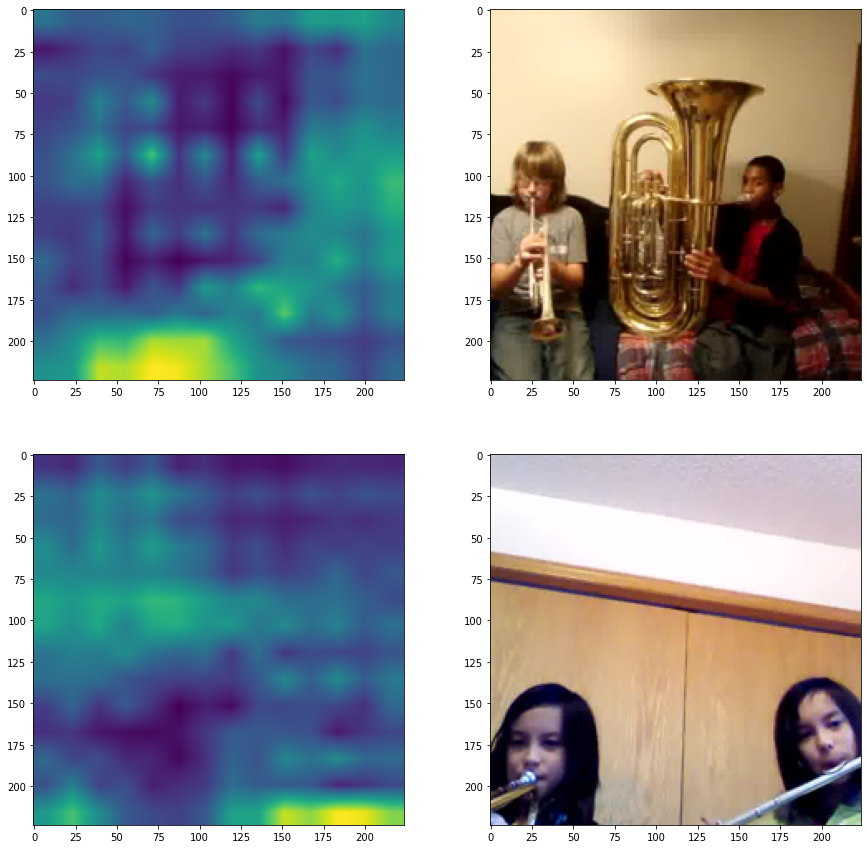

In [16]:
%matplotlib inline
ruta= "/content/Sound-of-Pixels/ckpt/MUSIC-2mix-LogFreq-resnet18dilated-unet7-linear-frames3stride24-maxpool-binary-weightedLoss-channels32-epoch100-step40_80/visualization/E_8W7f9ZZpY-E_8W7f9ZZpY+Zqg4DwXmYBI-Zqg4DwXmYBI"    
show_example(ruta, netWrapper=nw, val_loader=val_loader)

¡Los resultados se ven bastante mejor! La separación de audio es mejor. Y si nos fijamos en la localización, también vemos que parece funcionar mejor. Al parecer, nuestro pequeño experimento funcionó.

## Actividades

### Actividad 1

¿En cuál de las siguientes tareas (a grandes rasgos) cree que tiene sentido crear un modelo basado en audio y video vs uno solo de audio y otro de solo video? (*Puede haber más de 1 respuesta correcta. Cada respuesta incorrecta descontará 1 correcta. El puntaje mínimo es 0.*)


* A: Detección del estilo de baile que una persona está bailando en una discoteca.
* B: Detección de miembros de un equipo en un partido de fútbol.
* C: Detección de género músical de la música utilizada en un mall.
* D: Detección de ladrones en una joyería.
* E: Una aplicación que cuente personas en un parque de diversiones.



**Respuesta:** Escriba su respuesta aquí.

### Actividad 2
Imagínese que no se encuentra contento con la Resnet-18 ocupada en la Visual Analysis Network. ¿Cuál de las siguientes posibles arquitecturas cree que sería razonable (dado sus usos usuales) incluir? (*Puede haber más de 1 respuesta correcta. Cada respuesta incorrecta descontará 1 correcta. El puntaje mínimo es 0.*)

* A: Perceptrón Multicapa
* B: VGG19
* C: MAML
* D: LSTM
* E: Inception3D (I3D)


**Respuesta:** Escriba su respuesta aquí.

### Actividad 3

Si obtenemos un modelo preentrenado de algún repositorio y al replicar los resultados, obtenemos resultados **significativamente** distintos a los reportados por el autor. ¿Por qué puede estar pasando esto? (*Puede haber más de 1 respuesta correcta. Cada respuesta incorrecta descontará 1 correcta. El puntaje mínimo es 0.*)


* A: Código del autor no es la versión ocupada en el paper.
* B: Hubo cambios en alguna de las librerías utilizadas en el modelo.
* C: El método de preprocesar los datos no concuerda con lo hecho por el autor.
* D: Estamos corriendo el modelo en un computador con características de Hardware distintas al del autor.
* E: Por usar la configuración exacta de hiperparámetros que el autor usó.
* F: Usamos un batch size distinto a la hora de evaluar el modelo.

**Respuesta:** Escriba su respuesta aquí.

### Actividad 4 (Opcional/No Evaluada)
¿Qué potenciales aplicaciones ve para el uso de esta tecnología? Por ejemplo, en un trabajo posterior, los autores ocuparon `PixelPlayer` para identificar en video la ubicación de automóviles en condiciones nocturnas usando audio (http://sound-track.csail.mit.edu/). Piense no solo en la aplicación directa de mezclar video con sonido, sino de también utilizar un método semi-supervisado para entrenar un modelo.

## (Opcional) Crear el Dataset

A diferencia de otros datasets más tradicionales, el dataset MUSIC no es ofrecido directamente al público, sino que se proveen archivos .json que indican los IDs de los videos de Youtube asociados a cada ejemplo. El código de esta sección se encarga de hacer la descarga del dataset de forma automática, junto con procesarlo para que quede en el formato que requiere nuestro modelo. Esto toma unas cuantas horas en Colab.

### Código Descarga (> 10 horas)

In [ ]:
!git clone https://github.com/roudimit/MUSIC_dataset.git # Clonamos el repositorio del dataset para obtener los Youtube Ids

In [ ]:
!pip install youtube-dl -q # Librería de Python para descargar videos de Youtube (Controversial)

     |████████████████████████████████| 1.9MB 4.2MB/s 


In [ ]:
import json                         # Para leer archivos .json como diccionarios
import tqdm.notebook as tqdm        # Para tener %s de avance de nuestros loops
from os import mkdir, listdir       # Operaciones para manipular directorios
from os.path import join, isdir, isfile
import subprocess                   # Librería para ejecutar programas externos

'''
download_video(url, output_dir='output'): Se encarga de descargar un video de Youtube de acuerdo a su id.

Parámetros:
- url: id de youtube del video. Es lo que viene después de 'watch?v=' en la url
- output_dir: en qué directorio guardar el video descargado
'''

def download_video(url, output_dir="output"):
    
    filename = url
    if not isdir(output_dir):
        mkdir(output_dir)
    directory = join(output_dir,filename)
    if not isdir(directory):
        mkdir(directory)
    full_path = join(directory,filename+".mp4")

    if not isfile(full_path):
        command='youtube-dl -o {} {}'.format(full_path.replace(" ","\ "), "https://www.youtube.com/watch?v="+url)
        subprocess.run(command, shell=True)
    else:
        print("{} found. Skipping.".format(filename))
 

for folder in listdir("MUSIC_dataset"):
    if ".md" not in folder and ".git" not in folder:
        route = join("MUSIC_dataset", folder)
        print("Downloading files from {}".format(folder))
        data = json.load(open(route))

        o_dir = "MUSIC"
        if not isdir(o_dir):
            mkdir(o_dir)
        for k, ids in data['videos'].items():
            print("Downloading {}".format(k))
            output_dir = join(o_dir,k)
            for id in tqdm.tqdm(ids):
                download_video(id, output_dir=output_dir)
                # Extract frames
                # Extract mp3

## Preprocesamiento de los datos
El modelo toma como input frames de video (imágenes), sampleados a 8 fps, mientras que el audio debe ser sampleado a 11050 Hz. Para estas dos tareas, nuestro fiel programa `ffmpeg` será nuestro aliado.

#### Obteniendo los Frames

In [ ]:
import json                         # Para leer archivos .json como diccionarios
import tqdm.notebook as tqdm        # Para tener %s de avance de nuestros loops
from os import mkdir, listdir       # Operaciones para manipular directorios
from os.path import join, isdir, isfile
import subprocess                   # Librería para ejecutar programas externos

data_folder = "MUSIC"               # Directorio con los videos
output_folder = "MUSIC_proc/frames" # Directorio de salida para los frames

if not isdir("MUSIC_proc"):
    mkdir("MUSIC_proc")
if not isdir(output_folder):
    mkdir(output_folder)

folder=""
sample_folder=""
for folder in tqdm.tqdm(listdir(data_folder), desc="Folder {}: ".format(folder)):
    path = join(data_folder,folder)
    output_path = join(output_folder, folder)
    if not isdir(output_path):
        mkdir(output_path)
    for sample_folder in tqdm.tqdm(listdir(path), desc="Folder {}: ".format(sample_folder)):
        folder_path = join(path, sample_folder)
        output_folder_path = join(output_path, sample_folder)
        if not isdir(output_folder_path):
            mkdir(output_folder_path)
        for sample in listdir(folder_path):
            full_path = join(folder_path, sample)
            # Tomando los frames
            command = "ffmpeg -i {} -filter:v fps=fps=8 {}/%6d.jpg".format(full_path.replace(" ","\ "),output_folder_path.replace(" ","\ "))
            subprocess.run(command, shell=True, check=True)

#### Muestreando el Audio

In [ ]:
import json                         # Para leer archivos .json como diccionarios
import tqdm.notebook as tqdm        # Para tener %s de avance de nuestros loops
from os import mkdir, listdir       # Operaciones para manipular directorios
from os.path import join, isdir, isfile
import subprocess                   # Librería para ejecutar programas externos

data_folder = "MUSIC"               # Directorio con los videos
output_folder = "MUSIC_proc/audio"  # Donde queremos dejar el audio

if not isdir("MUSIC_proc"):
    mkdir("MUSIC_proc")
if not isdir(output_folder):
    mkdir(output_folder)

folder=""
sample_folder=""
for folder in tqdm.tqdm(listdir(data_folder), desc="Folder {}: ".format(folder)):
    path = join(data_folder,folder)
    output_path = join(output_folder, folder)
    if not isdir(output_path):
        mkdir(output_path)
    for sample_folder in tqdm.tqdm(listdir(path), desc="Folder {}: ".format(sample_folder)):
        folder_path = join(path, sample_folder)
        output_folder_path = join(output_path, sample_folder)
        if not isdir(output_folder_path):
            mkdir(output_folder_path)
        for sample in listdir(folder_path):
            full_path = join(folder_path, sample)
            command = "ffmpeg -i {} -q:a 0 -map a -ar 11025 {}/{}.mp3".format(full_path.replace(" ","\ "),
                                                                              output_folder_path.replace(" ","\ "),
                                                                              sample.split(".")[0])
            subprocess.run(command, shell=True, check=True)

### Generando Splits del Dataset

In [ ]:
import os
import glob
import argparse
import random
import fnmatch
from easydict import EasyDict as edict

def find_recursive(root_dir, ext='.mp3'):
    files = []
    for root, dirnames, filenames in os.walk(root_dir):
        for filename in fnmatch.filter(filenames, '*' + ext):
            files.append(os.path.join(root, filename))
    return files

args=edict()
args.root_audio = "../MUSIC_proc/audio"  # Carpeta con los mp3s
args.root_frame = "../MUSIC_proc/frames" # Carpeta con los frames (.jpgs)
args.fps = 8
args.path_output = "../MUSIC_proc"       # Donde queremos guardar el resultado
args.trainset_ratio = 0.8
# find all audio/frames pairs
infos = []
audio_files = find_recursive(args.root_audio, ext='.mp3')
for audio_path in audio_files:
    frame_path = audio_path.replace(args.root_audio, args.root_frame) \
                            .replace('.mp3', '.mp4')
    frame_path = "/".join(frame_path.split("/")[:-1])
    frame_files = glob.glob(frame_path + '/*.jpg')

    if len(frame_files) > args.fps * 20:
        infos.append(','.join([audio_path, frame_path, str(len(frame_files))]))
print('{} audio/frames pairs found.'.format(len(infos)))

# split train/val
n_train = int(len(infos) * 0.8)
random.shuffle(infos)
trainset = infos[0:n_train]
valset = infos[n_train:]
for name, subset in zip(['train', 'val'], [trainset, valset]):
    filename = '{}.csv'.format(os.path.join(args.path_output, name))
    with open(filename, 'w') as f:
        for item in subset:
            f.write(item + '\n')
    print('{} items saved to {}.'.format(len(subset), filename))

print('Done!')


144 audio/frames pairs found.
115 items saved to ../MUSIC_proc/train.csv.
29 items saved to ../MUSIC_proc/val.csv.
Done!
